In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from collections import Counter
from typing import NamedTuple
import regex as re

# Requires LaTeX
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
import scienceplots
plt.style.use(['science','ieee'])

In [8]:
def trim_county_name(county):
    parts = county.split()
    if len(parts) > 1 and re.sub(r'[^\w]', '', parts[-1]).lower() in ("co", "county", "mun", "par", "prov"):
        return " ".join(parts[:-1])
    else:
        return county

In [20]:
# LLM = "llama2-7b"
# LLM = "gpt-3.5-turbo-0613"
LLM = "gpt-4-1106-preview"
US_MAPS_RESULTS_WITH_UMS = f"../results/us-maps/{LLM}/results-with-ums.tsv"

df = pd.read_csv(US_MAPS_RESULTS_WITH_UMS, sep="\t")
df["species"] = df["kingdom"] + " " + df["genus"] + " " + df["specificepithet"]
df["county"] = df["county"].map(trim_county_name)
raw_us_df = df

IDIGBIO_SAMPLE_RESULTS_WITH_UMS = f"../results/idigbio-sample/{LLM}/results-with-ums.tsv"

df = pd.read_csv(IDIGBIO_SAMPLE_RESULTS_WITH_UMS, sep="\t")
df["species"] = df["kingdom"] + " " + df["genus"] + " " + df["specificepithet"]
df["county"] = df["county"].map(trim_county_name)
raw_full_df = df

In [63]:
def get_continental_counties(path_to_state_counties_tsv, path_to_counties_shp, path_to_states_shp):
    state_name_map = gpd.read_file(path_to_states_shp)[["STATEFP", "NAME"]].set_index("STATEFP")["NAME"]

    df = pd.read_csv(path_to_state_counties_tsv, sep="\t")[["state", "county"]]
    df = df.set_index(df["state"] + ", " + df["county"])

    gdf = gpd.read_file(path_to_counties_shp)[["STATEFP", "NAMELSAD", "geometry"]]
    gdf = gdf.set_index(gdf["STATEFP"].apply(lambda x: state_name_map[x]) + ", " + gdf["NAMELSAD"])

    return gdf.join(df, how="right")[["geometry"]]

geo_df = get_continental_counties(\
    "../resources/us-maps/us-state-counties.tsv",
    "../resources/us-maps/tl_2022_us_county/tl_2022_us_county.shp",
    "../resources/us-maps/tl_2022_us_state/tl_2022_us_state.shp")
geo_df = geo_df.reset_index()
geo_df["stateprovince"] = geo_df.apply(axis=1, func=lambda r: r["index"].split(", ")[0])
geo_df["county"] = geo_df.apply(axis=1, func=lambda r: trim_county_name(r["index"].split(", ")[1]))
geo_df = geo_df.drop(axis=0, columns=["index"])

geo_df.head(1)

,geometry,stateprovince,county
0,"POLYGON ((-86.58826 32.36775, -86.58834 32.367...",Alabama,Autauga


In [16]:
response_features = {
    'um1_total_score',
    'um1_percent_score',
    'um2_abstains'
}

acc_features = {
    'um3_accuracy_by_kingdom',
    'um3_accuracy_by_phylum',
    "um3_accuracy_by_family",
    'um3_accuracy_by_country',
    'um3_accuracy_by_stateprovince'
}

phrasing_features = {
    'um4_phrasing_agreement',
    'um4_phrasing_score_var'
}

idb_features = {
    'um5_record_count_by_phylum',
    'um5_record_count_by_family',
    'um5_record_count_by_genus',
    'um5_record_count_by_species',
    'um5_record_count_by_stateprovince',
    'um5_record_count_by_county'
}

taxonomy_features = {
    'um6_taxqa_accuracy_by_phylum',
    'um6_taxqa_accuracy_by_class',
    'um6_taxqa_accuracy_by_order',
    'um6_taxqa_accuracy_by_family',
    'um6_taxqa_accuracy_by_genus',
    'um7_taxqa_responses_by_phylum',
    'um7_taxqa_responses_by_class',
    'um7_taxqa_responses_by_order',
    'um7_taxqa_responses_by_family',
    'um7_taxqa_responses_by_genus'
}

basic_features = list(set()\
    | response_features\
    | phrasing_features\
    | idb_features\
    | taxonomy_features\
)

ext_features = list(set(basic_features) | acc_features)

In [25]:
def get_acc_by_field(df, fields, prior_counts=1) -> pd.Series:
    new_index = df.groupby(fields).size().index
    def fill_blanks(series):
        return series.reindex(new_index, fill_value=0)
    
    subset = True
    num_correct = prior_counts + fill_blanks(df[subset * (df["correct"] == 1)].groupby(fields).size())
    num_incorrect = prior_counts + fill_blanks(df[subset * (df["correct"] == -1)].groupby(fields).size())
    
    return num_correct / (num_correct + num_incorrect)

acc_by_kingdom = get_acc_by_field(raw_full_df, ["kingdom"])

def get_field_acc(accs, record):
    i = tuple(record[accs.index.names])
    if i in accs.index:
        return accs.loc[i]
    else:
        return acc_by_kingdom.loc[record["kingdom"]]

def add_acc_ums(train_df, test_df):
    df = train_df
    acc_by_kingdom = get_acc_by_field(train_df, ["kingdom"])
    acc_by_phylum = get_acc_by_field(df, ["kingdom", "phylum"])
    acc_by_family = get_acc_by_field(df, ["kingdom", "phylum", "family"])
    # acc_by_genus = get_acc_by_field(df, ["kingdom", "phylum", "family", "genus"])
    # acc_by_species = get_acc_by_field(df, ["kingdom", "phylum", "family", "genus", "specificepithet"])
    acc_by_country = get_acc_by_field(df, ["country"])
    acc_by_stateprovince = get_acc_by_field(df, ["stateprovince"])
    # acc_by_county = get_acc_by_field(df, ["county"])

    def get_ums(record):
        r = record

        # Positively oriented, i.e. higher values = more certainty
        return pd.Series({    
            "um3_accuracy_by_kingdom": 1 - get_field_acc(acc_by_kingdom, r),
            "um3_accuracy_by_phylum": 1 - get_field_acc(acc_by_phylum, r),
            "um3_accuracy_by_family": 1 - get_field_acc(acc_by_family, r),
            # "um3_acc_by_genus": 1 - get_field_acc(acc_by_genus, r),
            # "um3_acc_by_species": 1 - get_field_acc(acc_by_species, r),
            "um3_accuracy_by_country": 1 - get_field_acc(acc_by_country, r),
            "um3_accuracy_by_stateprovince": 1 - get_field_acc(acc_by_stateprovince, r),
            # "um3_acc_by_county": 1 - get_field_acc(acc_by_county, r),
        })

    train_df = pd.concat([train_df.apply(lambda row: get_ums(row), axis=1), train_df], axis=1)
    test_df = pd.concat([test_df.apply(lambda row: get_ums(row), axis=1), test_df], axis=1)
    return (train_df, test_df)

full_df, us_df = add_acc_ums(raw_full_df, raw_us_df)

In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier

def train_conf_model(train_df, features):
    return HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.01,
        min_samples_leaf=10,
        max_iter=200,
        monotonic_cst=np.ones_like(features, dtype=int)
    ).fit(train_df[features], train_df["correct"])

conf_model = train_conf_model(full_df, ext_features)

In [84]:
probs = conf_model.predict_proba(us_df[ext_features])
probs[:,1]

scores_df = us_df[["stateprovince", "county", "prediction", "species"]].copy()
scores_df["scores"] = probs[:,1]
scores_df["presence"] = scores_df.apply(axis=1, func=lambda r: r["scores"] if r["prediction"] == 1 else 1 - r["scores"])
scores_df.head(1)

,stateprovince,county,prediction,species,scores,presence
0,Alabama,Autauga,-1,plantae acer saccharum,0.546504,0.453496


In [122]:
heatmap_df = pd.merge(scores_df, geo_df)
heatmap_df.head(1)[["stateprovince", "county", "presence", "prediction", "species", "geometry"]]

,stateprovince,county,presence,prediction,species,geometry
0,Alabama,Autauga,0.453496,-1,plantae acer saccharum,"POLYGON ((-86.58826 32.36775, -86.58834 32.367..."


In [313]:

import matplotlib as mpl
cmap = mpl.cm.coolwarm

In [329]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

cmap = mpl.cm.coolwarm
norm = mpl.colors.BoundaryNorm(np.arange(0, 1, 0.01), cmap.N)

def plot_scores(df, name=None, score_field="presence", dpi=300, cmap='Reds', alpha=1):    
    s = 1.7
    f, ax = plt.subplots(1,1, figsize=(2 * s, 1 * s), sharex=True, sharey=True, dpi=dpi)
    # plt.title(f"Occurrence map of {name}")
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="2%", pad=-.2 * s)
    heatmap = gpd.GeoDataFrame(df).plot(score_field, ax=ax, alpha=alpha, cmap=cmap, norm=norm, edgecolor='k', legend=False, linewidth=.05)#,
                                #   legend_kwds=dict(alpha=alpha, shrink=.3, fraction=1))
    ax.margins(0)
    ax.axis('off')
    plt.show()

75.09% +- 13.80%


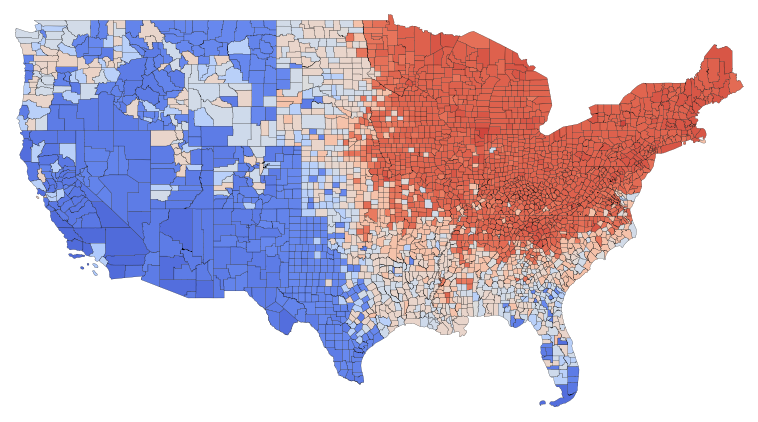

In [330]:
t = 0 #0.8
df = heatmap_df[heatmap_df["scores"] > t][heatmap_df["species"] == "plantae acer saccharum"]
print(f'{df["scores"].mean():.2%} +- {df["scores"].std():.2%}')
plot_scores(df, "Acer saccharum", "presence", cmap="coolwarm")

67.91% +- 11.56%


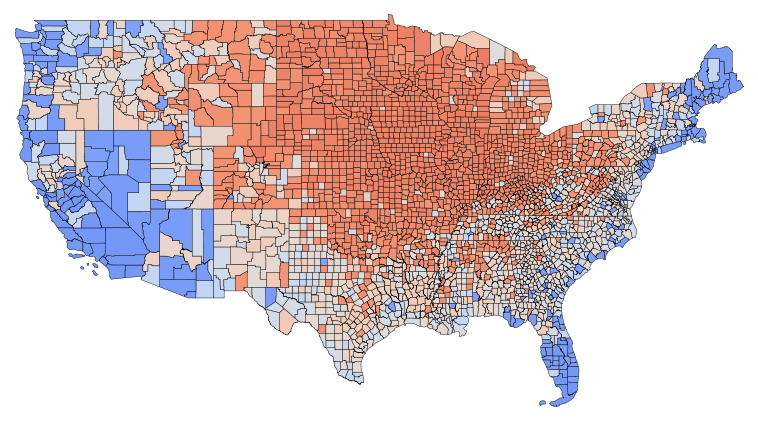

In [326]:
t = 0
df = heatmap_df[heatmap_df["scores"] > t][heatmap_df["species"] == "plantae amorpha canescens"]
print(f'{df["scores"].mean():.2%} +- {df["scores"].std():.2%}')
plot_scores(df, "Amorpha canescens", "presence", cmap="coolwarm")

69.10% +- 10.81%


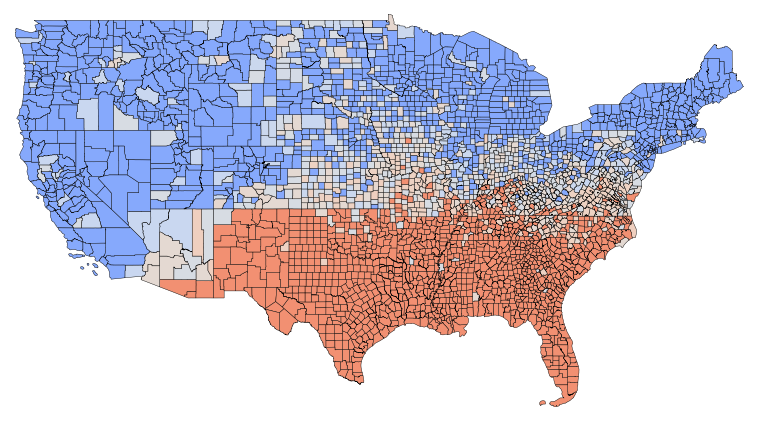

In [325]:
t = 0
df = heatmap_df[heatmap_df["scores"] > t][heatmap_df["species"] == "animalia dasypus novemcinctus"]
print(f'{df["scores"].mean():.2%} +- {df["scores"].std():.2%}')
plot_scores(df, "Dasypus novemcinctus", "presence", cmap="coolwarm")

57.28% +- 8.37%


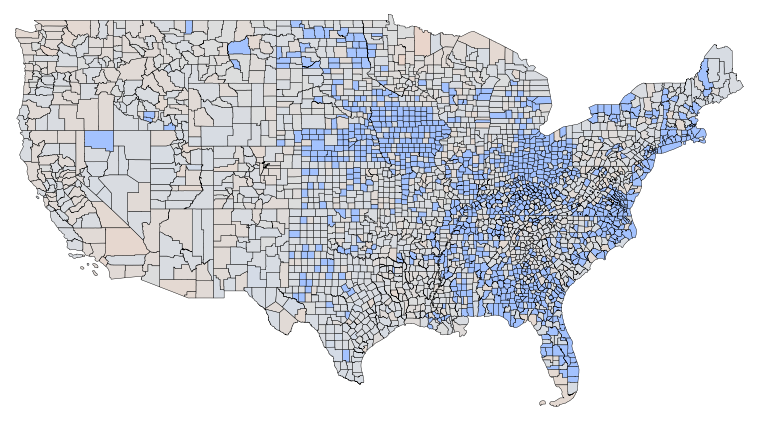

In [324]:
t = 0
df = heatmap_df[heatmap_df["scores"] > t][heatmap_df["species"] == "animalia leuconotopicus albolarvatus"]
print(f'{df["scores"].mean():.2%} +- {df["scores"].std():.2%}')
plot_scores(df, "Leuconotopicus albolarvatus", "presence", cmap="coolwarm")

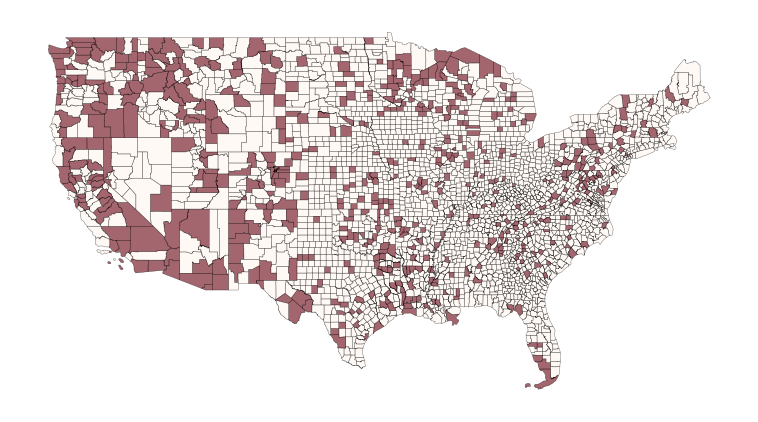

In [246]:
d = heatmap_df[heatmap_df["species"] == "animalia leuconotopicus albolarvatus"]
plot_scores(d, "leuconotopicus albolarvatus", "prediction", cmap="Reds")

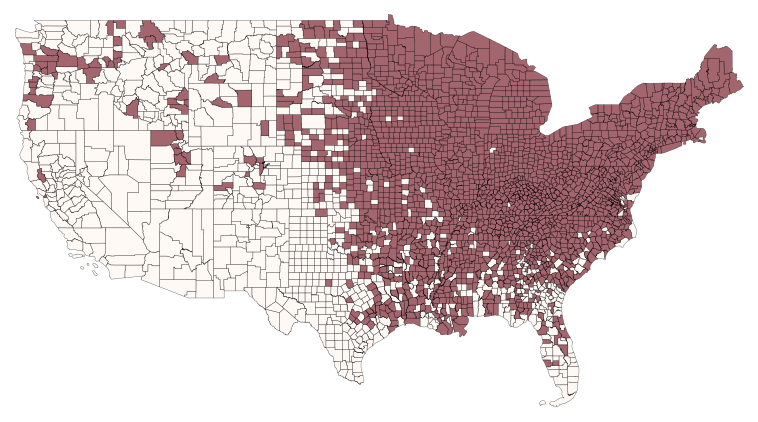

In [303]:
d = heatmap_df[heatmap_df["species"] == "plantae acer saccharum"]
plot_scores(d, "Acer saccharum", "prediction")

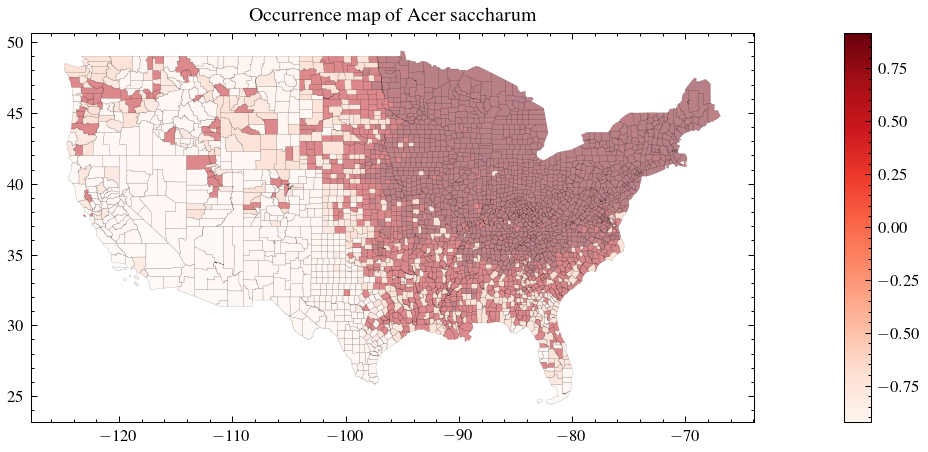

In [124]:
d = heatmap_df[heatmap_df["species"] == "plantae acer saccharum"].copy()
d["scores"] = d["prediction"] * d["scores"]
plot_scores(d, "Acer saccharum", "scores")